## Задача 1

Реализовать класс для работы с линейной регрессией

In [37]:
import pandas as pd
import numpy as np
import time

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, r2_score

import matplotlib.pyplot as plt
import seaborn as sns

In [12]:
class MyLinearRegression:
    """
    Parameters
    ----------
    regularization : {None, 'l1', 'l2', 'l1l2'}, default=None
        Какую регуляризацию добавить к модели. Если значение `None`, то без регуляризации.

    weight_calc : {'matrix', 'gd', 'sgd'}, default='matrix'
        Каким образом вычислять вектор весов: матрично ('matrix'), градиентным спуском ('gd') или стохастическим градиентным спуском ('sgd'). При этом, при 'l1' или 'l1l2' нельзя использовать параметр 'matrix'.

    Attributes
    ----------
    coefs_ : Вектор коэффициентов размера (p, 1), где p — количество признаков.
    intercept_ : Значение коэффициента, отвечающего за смещение
    """

    #__init__ — это конструктор класса. Конструктор — это специальный метод, который автоматически вызывается, когда мы создаём объект класса.
    def __init__(self, regularization=None, weight_calc='matrix', lambda_1=None, lambda_2=None, batch_size=20, random_state=42, max_iter=1000, learning_rate=0.01, early_stopping=0.0001):

        #Проверка корректности параметров
        if regularization not in [None, 'l1', 'l2', 'l1l2']:
            raise TypeError(f"Параметр regularization не может принимать значение '{regularization}'")
        if weight_calc not in ['matrix', 'gd', 'sgd']: 
            raise TypeError(f"Параметр weight_calc не может принимать значение '{weight_calc}'")
        if regularization in ['l1', 'l1l2'] and lambda_1 is None: 
            raise TypeError(f"Значение коэффициента регулризации l1 не задано")
        if regularization in ['l2', 'l1l2'] and lambda_2 is None: 
            raise TypeError(f"Значение коэффициента регулризации l2 не задано")
        if regularization in ['l1', 'l1l2'] and weight_calc == 'matrix': 
            raise TypeError(f"Параметр weight_calc не может принимать значение 'matrix' при регуляризации'{regularization}'")

        self.regularization = regularization
        self.weight_calc = weight_calc
        self.lambda_1 = lambda_1
        self.lambda_2 = lambda_2
        self.batch_size = batch_size
        self.random_state = random_state
        self.max_iter = max_iter
        self.learning_rate = learning_rate
        self.early_stopping = early_stopping


        self.coefs_ = None 
        self.intercept_ = None


    def fit(self, X, y): 
      #Проверяем, является ли X объектом pandas (DataFrame или Series). Если да, то превращаем его в numpy массив через X.values
      if isinstance(X, (pd.DataFrame, pd.Series)): 
        X = X.values
      if isinstance(y, (pd.DataFrame, pd.Series)): 
        y = y.values
      X_with_intercept = np.concatenate(([[1]]*X.shape[0], X), axis=1) 
      np.random.seed(self.random_state) 
      theta = np.random.uniform(-0.01, 0.01, X_with_intercept.shape[1]) 

      if self.weight_calc == 'matrix': 
        if self.regularization == 'l2':
          indentity = np.eye(X_with_intercept.shape[1]) 
          indentity[0, 0] = 0 
          theta = np.linalg.inv(X_with_intercept.T @ X_with_intercept + self.lambda_2*indentity) @ X_with_intercept.T @ y 
        else:
          #Если регуляризация отсутствует, просто решаем обычное уравнение
          theta = np.linalg.inv(X_with_intercept.T @ X_with_intercept) @ X_with_intercept.T @ y 

      else:
        for _ in range(self.max_iter): 
          if self.weight_calc == 'gd': 
            gradient = -(2/X_with_intercept.shape[0])*X_with_intercept.T @ (y - X_with_intercept @ theta) 
            if self.regularization in ['l1', 'l1l2']: 
              gradient[1:] += self.lambda_1*np.sign(theta[1:])
            if self.regularization in ['l2', 'l1l2']: 
              gradient[1:] += 2*self.lambda_2*theta[1:]
            if np.linalg.norm(gradient) < self.early_stopping: 
              break
            #Обновляем коэффициенты по правилу градиентного спуска:
            theta -= self.learning_rate*gradient 

          elif self.weight_calc == 'sgd': 
            stop = False 
            indices = np.random.permutation(X_with_intercept.shape[0]) 
            X_shuffled = X_with_intercept[indices] 
            y_shuffled = y[indices] 
            # Цикл по батчам (подвыборкам) размера batch_size
            for j in range(0, X_with_intercept.shape[0]-self.batch_size, self.batch_size): 
              #Вычисляем градиент MSE по батчу, а не по всей выборке
              gradient = -(2/self.batch_size)*X_shuffled[j:j+self.batch_size].T @ (y_shuffled[j:j+self.batch_size] - X_shuffled[j:j+self.batch_size] @ theta)  
              if self.regularization in ['l1', 'l1l2']: 
                gradient[1:] += self.lambda_1*np.sign(theta[1:]) #[1:] — не трогаем intercept
              if self.regularization in ['l2', 'l1l2']: 
                gradient[1:] += 2*self.lambda_2*theta[1:] 
              if np.linalg.norm(gradient) < self.early_stopping: 
                stop = True
                break
              theta -= self.learning_rate*gradient
            if stop:
              break

      self.intercept_ = theta[0] #Берём первый элемент вектора theta и сохраняем его как intercept_.
      self.coefs_ = theta[1:] #Остальные элементы вектора theta — это коэффициенты модели для признаков. Сохраняем их в атрибут coefs_, чтобы потом использовать для предсказаний.
      return self 


    def predict(self, X: np.array, ss=True): 
      if self.coefs_ is None: 
        raise ValueError("Модель должна быть обучена перед предсказанием")
      return X @ self.coefs_ + self.intercept_ 


    def score(self, X: np.array, y: np.array): 
      ss_res = sum((y - self.predict(X))**2) 
      ss_tot = sum((y - np.mean(y))**2) 
      return 1 - (ss_res/ss_tot) 


Используя датасет про автомобили (целевой признак — price), сравнить (качество, скорость обучения и предсказания, важность признаков) модели `MyLinearRegression` с различными гиперпараметрами, сделать выводы. На этом же датасете сравнить модель `MyLinearRegression` с библиотечной реализацией из `sklearn`, составить таблицу(ы) (графики) результатов сравнения (качество, скорость обучения и предсказания, важность признаков).

In [29]:
df = pd.read_csv('Used_fiat_500_in_Italy_dataset.csv')

y = df['price']

X = df.drop(columns=['price'])
X = pd.get_dummies(X, columns=['model','transmission'], drop_first=True)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [30]:
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns = X_train.columns) 
X_test = pd.DataFrame(scaler.transform(X_test), columns = X_test.columns)

In [31]:
#Функция оценки модели
def evaluate_model(name, model, X_train, y_train, X_test, y_test):
    
    start_fit = time.time() 
    model.fit(X_train, y_train) 
    end_fit = time.time() 

    start_pred = time.time() 
    y_pred = model.predict(X_test) 
    end_pred = time.time() 

    results = [
        r2_score(y_test, y_pred), 
        mean_absolute_error(y_test, y_pred), 
        end_fit - start_fit, 
        end_pred - start_pred 
    ]

    coefs = getattr(model, 'coefs_', None) 
    if coefs is None:
        # Если coef_ нет — берем стандартное имя коэффициентов в sklearn.
        coefs = model.coef_ 

    return name, np.round(results, 4), np.round(coefs, 3)


In [32]:
results_dict = {} 
importance_of_features = {} 

my_lr_configs = [ 
    ('MyLR matrix', dict(weight_calc='matrix')), 
    ('MyLR matrix l2', dict(weight_calc='matrix', regularization='l2', lambda_2=10)),
    ('MyLR gd', dict(weight_calc='gd')), 
    ('MyLR gd l1', dict(weight_calc='gd', regularization='l1', lambda_1=10)),
    ('MyLR gd l2', dict(weight_calc='gd', regularization='l2', lambda_2=0.1)), 
    ('MyLR gd l1l2', dict(weight_calc='gd', regularization='l1l2', lambda_1=0.1, lambda_2=0.1)), 
    ('MyLR sgd', dict(weight_calc='sgd')), 
    ('MyLR sgd l1', dict(weight_calc='sgd', regularization='l1', lambda_1=1)), 
    ('MyLR sgd l2', dict(weight_calc='sgd', regularization='l2', lambda_2=0.01)), 
    ('MyLR sgd l1l2', dict(weight_calc='sgd', regularization='l1l2', lambda_1=0.1, lambda_2=0.01)),
]

for name, params in my_lr_configs:
    model = MyLinearRegression(**params) 
    name, res, coefs = evaluate_model( 
        name, 
        model, 
        X_train.values, 
        y_train.values,
        X_test.values,
        y_test.values
    )
    results_dict[name] = res 
    importance_of_features[name] = coefs 

In [34]:
#библиотечная реализация sklearn
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, SGDRegressor

sklearn_models = [
    ('sklearn LR', LinearRegression()),
    ('sklearn Ridge', Ridge(alpha=10, random_state=42)),
    ('sklearn Lasso', Lasso(alpha=10, random_state=42)),
    ('sklearn ElasticNet', ElasticNet(alpha=0.1, l1_ratio=0.5, random_state=42)), 
    ('sklearn SGDRegressor', SGDRegressor(alpha=0.05, l1_ratio=0.5, random_state=42)),
]

for name, model in sklearn_models: 
    name, res, coefs = evaluate_model(
        name,
        model,
        X_train,
        y_train,
        X_test,
        y_test
    )
    results_dict[name] = res 
    importance_of_features[name] = coefs

In [27]:
results_table = pd.DataFrame.from_dict(
    results_dict,
    orient='index',
    columns=['r2_score', 'MAE', 'train_time', 'pred_time']
)
results_table

,r2_score,MAE,train_time,pred_time
MyLR matrix,0.8945,559.2244,0.0000,0.000
MyLR matrix l2,0.8927,561.8715,0.0010,0.000
MyLR gd,0.8944,559.4996,0.0088,0.000
MyLR gd l1,0.8935,560.4104,0.0070,0.000
MyLR gd l2,0.8866,575.2567,0.0070,0.000
MyLR gd l1l2,0.8866,575.2943,0.0080,0.000
MyLR sgd,0.8943,560.2905,0.0777,0.000
MyLR sgd l1,0.8942,560.3863,0.1009,0.000
MyLR sgd l2,0.8938,560.4657,0.0935,0.000
MyLR sgd l1l2,0.8938,560.4824,0.1100,0.000


C:\Users\nikgr\AppData\Local\Temp\ipykernel_16912\4062388456.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
C:\Users\nikgr\AppData\Local\Temp\ipykernel_16912\4062388456.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
C:\Users\nikgr\AppData\Local\Temp\ipykernel_16912\4062388456.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
C:\Users\nikgr\AppData\Local\Temp\ipykernel_16912\4062388456.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` 

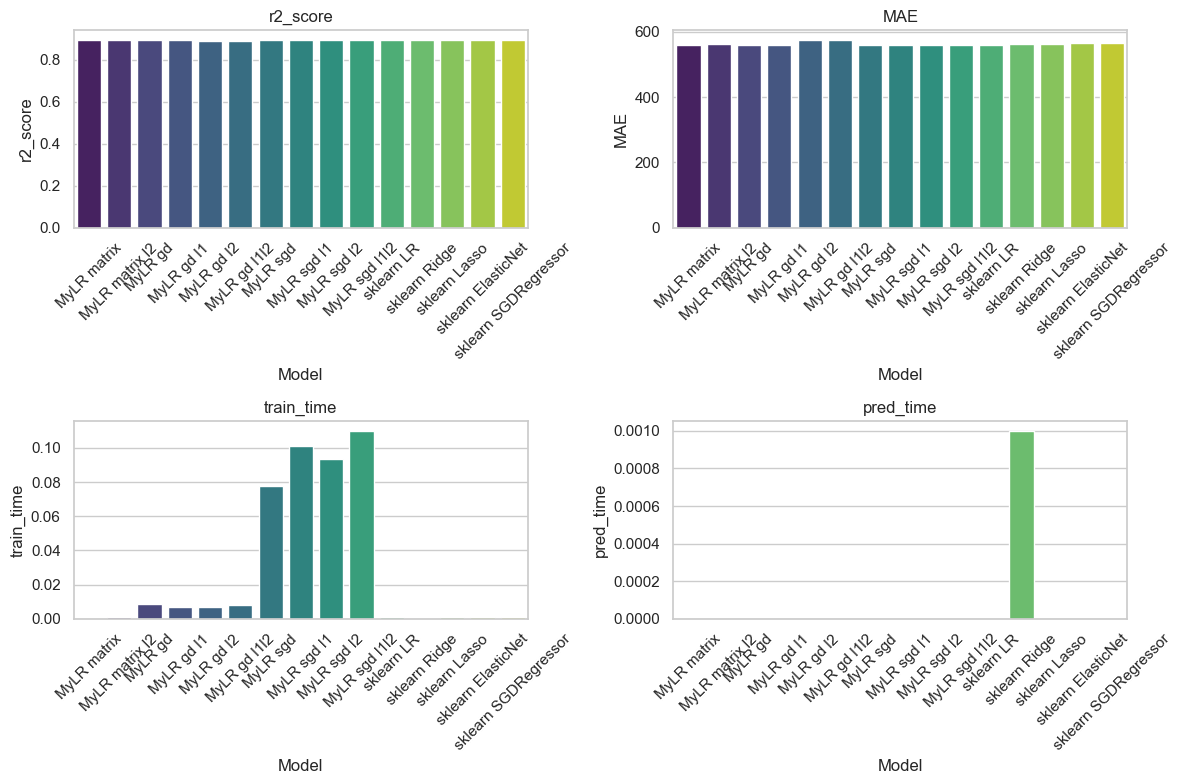

In [38]:
# Настройка стиля
sns.set(style="whitegrid")
plt.figure(figsize=(12, 8))

metrics = ['r2_score', 'MAE', 'train_time', 'pred_time']

for i, metric in enumerate(metrics, 1):
    plt.subplot(2, 2, i)
    sns.barplot(
        x=results_table.index, 
        y=results_table[metric], 
        palette="viridis"
    )
    plt.title(metric)
    plt.xticks(rotation=45)
    plt.ylabel(metric)
    plt.xlabel("Model")

plt.tight_layout()
plt.show()


In [28]:
importance_df = pd.DataFrame.from_dict(
    importance_of_features,
    orient='index',
    columns=X_train.columns
)
importance_df

,engine_power,age_in_days,km,previous_owners,lat,lon,model_pop,model_sport,model_star,transmission_manual
MyLR matrix,39.824,-1533.838,-556.685,50.413,194.474,252.261,46.635,54.641,35.701,-3.125
MyLR matrix l2,29.641,-1457.151,-586.439,50.083,166.267,222.380,35.296,43.546,40.796,-5.652
MyLR gd,39.804,-1531.712,-558.592,50.498,192.658,250.528,46.389,54.404,35.842,-3.301
MyLR gd l1,33.677,-1528.960,-550.809,43.651,167.664,224.219,37.894,47.221,32.014,-0.093
MyLR gd l2,12.006,-1334.061,-622.277,48.466,125.954,178.223,17.618,25.705,48.746,-8.963
MyLR gd l1l2,11.950,-1334.029,-622.218,48.407,125.787,178.047,17.543,25.641,48.707,-8.909
MyLR sgd,41.290,-1529.793,-556.645,54.422,192.985,248.331,44.609,56.165,33.490,-0.474
MyLR sgd l1,40.687,-1529.506,-555.884,53.760,190.448,245.656,43.778,55.449,33.190,-0.176
MyLR sgd l2,38.075,-1505.131,-566.753,54.341,183.723,238.612,40.956,52.491,35.172,-1.306
MyLR sgd l1l2,38.015,-1505.102,-566.679,54.276,183.482,238.358,40.873,52.420,35.141,-1.275


## Вывод

Проведя анализ всех моделей, видно, что наилучшее качество показали модели без регуляризации и с минимальной L2-регуляризацией. Введение сильной регуляризации или комбинированных штрафов L1+L2 немного ухудшает качество предсказания
т.е. в данной задаче регуляризация не даёт значимых преимуществ по качеству, но может быть полезна для предотвращения переобучения на более сложных или шумных данных

По таблице важности признаков можно понять, какие переменные сильнее всего влияют на цену автомобиля. В наших моделях наиболее значимыми переменные:  age_in_days, km, lat, lon

Также видно, что применение регуляризации снижает абсолютные значения коэффициентов: L2 и L1L2 «сжимают» веса, что помогает уменьшить влияние менее значимых признаков. При этом направление влияния признаков сохраняется для всех моделей

## Задача 2

[Соревнование на Kaggle](https://kaggle.com/competitions/yadro-regression-2025)